# 6.1 Modelos de Regressão: Ridge Regression e Árvores de Regressão

Este notebook explora diferentes modelos de regressão para análise de dados, incluindo Ridge Regression, utilizando técnicas de pré-processamento como transformação Box-Cox e seleção de variáveis. O objetivo é avaliar o desempenho dos modelos em termos de métricas como RMSE², tanto nos datasets completos quanto após a remoção de outliers das questões do Enem (vetorizadas).

In [ ]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

O dataset utilizado será o com 50 dimensões pois foi o que obteve os melhores resultados na Regressão Linear

In [21]:
# Leitura do dataset com 50 dimensões
df = pd.read_pickle('../data/final/enem_data_final.pkl')
df.head()

,numero_questao,gabarito,NU_PARAM_A,nu_param_B,NU_PARAM_C,ANO,enunciado,alternativas,gabarito_texto,distratores,...,enunciado_embbedings_word2vec_50,gabarito_embbedings_word2vec_50,distratores_embbedings_word2vec_50,similaridade_enunciado_gabarito_50,similaridade_enunciado_distratores_50,similaridade_gabarito_distratores_50,resposta_llama,acerto_llamma,resposta_deepseek,acerto_deepseek
0,1,C,3.43894,0.97831,0.10855,2017,"No império africano do Mali, no século XIV, To...",A: isolamento geográﬁco do Saara ocidental; B...,posição relativa nas redes de circulação,isolamento geográﬁco do Saara ocidental; explo...,...,"[0.09772969, 0.013166125, -0.032748703, 0.0580...","[-0.04434625, 0.2105245, -0.18144351, 0.030336...","[0.12940213, 0.22066694, 0.0586984, 0.03139533...",0.251504,0.736054,0.426387,C,True,C,True
1,2,D,3.00837,0.49169,0.13877,2017,Após a Declaração Universal dos Direitos Human...,A: ataque feito pelos japoneses à base milita...,execução de judeus e eslavos presos em guetos ...,ataque feito pelos japoneses à base militar am...,...,"[-0.018823402, 0.07832528, -0.016192827, 0.027...","[0.21008351, 0.5248949, 0.03625112, 0.01772637...","[0.078055575, 0.19092263, -0.0076030395, -0.03...",0.634785,0.504648,0.587013,D,True,D,True
2,3,D,0.60432,3.25992,0.08798,2017,"A moralidade, Bentham exortava, não é uma ques...",A: fundamentação cientíﬁca de viés positivist...,racionalidade de caráter pragmático,fundamentação cientíﬁca de viés positivista; c...,...,"[-0.013062097, 0.038470805, -0.020605344, 0.05...","[0.16413634, -0.035050992, 0.08454134, 0.23227...","[0.1313074, 0.058539692, 0.0961813, 0.17813754...",0.655402,0.634760,0.763059,D,True,D,True
3,4,E,1.85031,0.57925,0.11344,2017,Fala-se muito nos dias de hoje em direitos do ...,A: modernização da educação escolar; B: atuali...,universalização do princípio da igualdade civil,modernização da educação escolar; atualização ...,...,"[-0.042833664, -0.01434522, -0.002431296, 0.01...","[0.102909006, 0.06116425, -0.13846825, 0.33034...","[0.11364358, 0.071867414, 0.046681672, 0.18046...",0.485125,0.628863,0.766145,E,True,E,True
4,5,C,2.46290,0.76307,0.17672,2017,Na Constituição da República Federativa do Bra...,A: etnia e miscigenação racial; B: sociedade...,espaço e sobrevivência cultural,etnia e miscigenação racial; sociedade e igual...,...,"[0.010493249, 0.11095436, 0.017243173, 0.05319...","[0.267512, -0.081234336, 0.08019033, 0.1294613...","[0.13863416, 0.16260158, -0.0043905806, 0.2472...",0.559584,0.707497,0.692311,C,True,C,True


In [32]:
df_final = df[["enunciado_embbedings_word2vec_50",
               "acerto_deepseek",
                "acerto_llamma",
                "similaridade_enunciado_gabarito_50",
                "similaridade_enunciado_distratores_50",
                "similaridade_gabarito_distratores_50",
               'nu_param_B']]
df_final.rename(columns={'nu_param_B': 'y', "enunciado_embbedings_word2vec_50":'X'}, inplace=True)
df_final.head()

/tmp/ipykernel_18682/2459947891.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.rename(columns={'nu_param_B': 'y', "enunciado_embbedings_word2vec_50":'X'}, inplace=True)


,X,acerto_deepseek,acerto_llamma,similaridade_enunciado_gabarito_50,similaridade_enunciado_distratores_50,similaridade_gabarito_distratores_50,y
0,"[0.09772969, 0.013166125, -0.032748703, 0.0580...",True,True,0.251504,0.736054,0.426387,0.97831
1,"[-0.018823402, 0.07832528, -0.016192827, 0.027...",True,True,0.634785,0.504648,0.587013,0.49169
2,"[-0.013062097, 0.038470805, -0.020605344, 0.05...",True,True,0.655402,0.634760,0.763059,3.25992
3,"[-0.042833664, -0.01434522, -0.002431296, 0.01...",True,True,0.485125,0.628863,0.766145,0.57925
4,"[0.010493249, 0.11095436, 0.017243173, 0.05319...",True,True,0.559584,0.707497,0.692311,0.76307


In [33]:
# Removendo observações Nan
df_final = df_final[df_final['y'].notna()].reset_index(drop=True)

## 6.1.1 Análise de correlação

In [34]:
# Explodindo a coluna X em várias colunas
df_features = pd.DataFrame(df_final['X'].tolist(), index=df_final.index)

df_features.columns = [f'X{i+1}' for i in range(df_features.shape[1])]

df_features.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,0.097730,0.013166,-0.032749,0.058064,0.066659,0.055518,0.005533,-0.010803,0.124288,-0.010112,...,-0.058407,0.149049,-0.103425,0.085180,0.109060,0.018974,0.037986,0.010234,-0.070827,-0.104570
1,-0.018823,0.078325,-0.016193,0.027615,0.080563,-0.001443,-0.011481,-0.011694,0.046921,-0.053186,...,0.060602,0.106786,0.061356,0.139279,0.123225,-0.019229,0.167333,0.101951,-0.028866,-0.109328
2,-0.013062,0.038471,-0.020605,0.051806,0.062729,-0.029429,0.076300,0.081863,0.074962,0.029681,...,0.061806,0.264843,0.080967,0.118467,0.042564,-0.042368,0.108510,0.100451,-0.141360,-0.054252
3,-0.042834,-0.014345,-0.002431,0.015723,0.100305,0.023464,0.047759,0.088246,0.083725,-0.059424,...,-0.084707,0.104256,0.096123,0.056716,0.125574,-0.014302,0.038790,0.018908,-0.013034,-0.059200
4,0.010493,0.110954,0.017243,0.053193,0.005365,-0.082108,0.063029,-0.078666,-0.008422,0.028746,...,0.009678,0.141793,0.088591,0.131339,0.022100,0.004114,0.075874,0.088452,-0.058793,-0.005872


<Axes: >

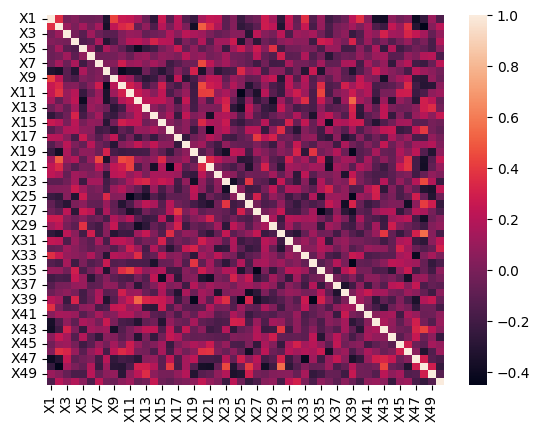

In [35]:
sns.heatmap(df_features.corr())

<Axes: >

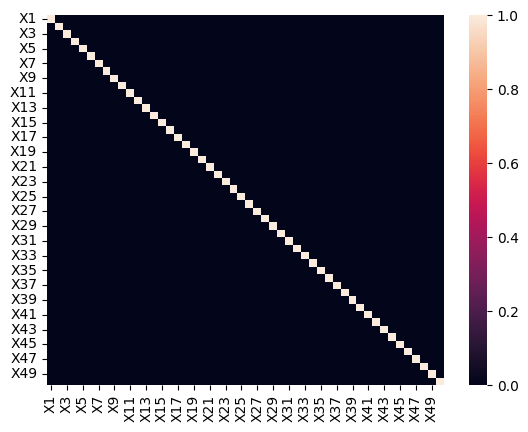

In [36]:
sns.heatmap(df_features.corr() > 0.7)

Como nenhuma correlação alta ou baixa foi encontrada, dar-se-á seguimento das análises com as 50 variáveis originais.

## 6.1.2 Ridge Regression

In [9]:
def cross_validate_ridge_rmse(X, y, alphas, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    alpha_rmse = {}

    for alpha in alphas:
        rmse_list = []

        for train_index, val_index in kf.split(X):
            # print(train_index)
            # print(val_index)
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            # print('hi')
            # print(list(train_index))
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # Adiciona o intercepto
            X_train_const = sm.add_constant(X_train)
            X_val_const = sm.add_constant(X_val)

            # Ajusta o modelo com regularização L2 (Ridge)
            model = sm.OLS(y_train, X_train_const)
            result = model.fit_regularized(alpha=alpha, L1_wt=0.0)

            # Predições
            y_pred = np.dot(X_val_const, result.params)

            # Calcula o RMSE
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            rmse_list.append(rmse)

        # Média dos RMSEs para o alpha atual
        alpha_rmse[alpha] = np.mean(rmse_list)

    return alpha_rmse


In [51]:
df_new = pd.concat([df_features, df_final.drop(['X', 'y'], axis=1)], axis=1)
df_new['acerto_llamma'] = df_new['acerto_llamma'].astype(float)
df_new['acerto_deepseek'] = df_new['acerto_deepseek'].astype(float)
df_new.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X46,X47,X48,X49,X50,acerto_deepseek,acerto_llamma,similaridade_enunciado_gabarito_50,similaridade_enunciado_distratores_50,similaridade_gabarito_distratores_50
0,0.097730,0.013166,-0.032749,0.058064,0.066659,0.055518,0.005533,-0.010803,0.124288,-0.010112,...,0.018974,0.037986,0.010234,-0.070827,-0.104570,1.0,1.0,0.251504,0.736054,0.426387
1,-0.018823,0.078325,-0.016193,0.027615,0.080563,-0.001443,-0.011481,-0.011694,0.046921,-0.053186,...,-0.019229,0.167333,0.101951,-0.028866,-0.109328,1.0,1.0,0.634785,0.504648,0.587013
2,-0.013062,0.038471,-0.020605,0.051806,0.062729,-0.029429,0.076300,0.081863,0.074962,0.029681,...,-0.042368,0.108510,0.100451,-0.141360,-0.054252,1.0,1.0,0.655402,0.634760,0.763059
3,-0.042834,-0.014345,-0.002431,0.015723,0.100305,0.023464,0.047759,0.088246,0.083725,-0.059424,...,-0.014302,0.038790,0.018908,-0.013034,-0.059200,1.0,1.0,0.485125,0.628863,0.766145
4,0.010493,0.110954,0.017243,0.053193,0.005365,-0.082108,0.063029,-0.078666,-0.008422,0.028746,...,0.004114,0.075874,0.088452,-0.058793,-0.005872,1.0,1.0,0.559584,0.707497,0.692311


In [52]:
# Separando os dados
X = df_new
y = df_final['y']


# Aplicando Transformações
add_list = [(y.min() * (-1)) + 1] * len(y)
y = y + add_list

# Aplicando Boxcox
y, _ = stats.boxcox(y)
y = pd.Series(y)

In [53]:
# Adiciona o intercepto
X = sm.add_constant(X)

# Definindo uma lista de valores de alpha para testar
alphas = np.logspace(-4, 4, 50)

# Executando a validação cruzada
alpha_rmse = cross_validate_ridge_rmse(X, y, alphas, cv=5)

# Encontrando o alpha com o menor RMSE médio
best_alpha = min(alpha_rmse, key=alpha_rmse.get)
print(f"Melhor alpha: {best_alpha}")
print(f"RMSE correspondente: {alpha_rmse[best_alpha]}")


Melhor alpha: 0.0062505519252739694
RMSE correspondente: 0.4740956964798059


In [54]:
# Separando em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Adiciona o intercepto
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Ajusta o modelo final com o melhor alpha encontrado
final_model = sm.OLS(y_train, X_train)
final_result = final_model.fit_regularized(alpha=best_alpha, L1_wt=0.0)

# Exibe os coeficientes
print(final_result.params)

[ 1.02042606 -0.17698057 -0.27266077 -0.23208406 -0.06039821 -0.17156229
 -0.04671901 -0.211484    0.15785096 -0.0067736  -0.03238782  0.11675194
  0.32969287  0.26329916  0.24985986 -0.04454019 -0.01388323 -0.24706828
  0.18401404  0.0354765  -0.01261795 -0.12096313 -0.13827109  0.02903455
 -0.1955033  -0.20360916  0.06546388 -0.5177916  -0.32186296 -0.00298423
  0.11395533  0.20426836  0.1334765  -0.16575697 -0.25055104  0.25983358
 -0.15037018  0.08229304  0.2242225   0.31344978  0.36039286 -0.2250889
  0.37149735 -0.18940032  0.12020726  0.39559194 -0.04536087 -0.0219482
  0.31396945  0.06186172 -0.09460654 -0.04167963 -0.06832441  0.53170663
 -0.0926386   0.3176172 ]


In [55]:
# Para o conjunto de treino
y_train_pred = final_result.predict(X_train)

# Para o conjunto de teste
y_test_pred = final_result.predict(X_test)

# Calculando os RMSE
rmse_train = root_mean_squared_error(y_train, y_train_pred)
rmse_test = root_mean_squared_error(y_test, y_test_pred)

print(f'RMSE no conjunto de Treino: {rmse_train}')
print(f'RMSE no conjunto de Teste: {rmse_test}')

RMSE no conjunto de Treino: 0.42514775003707267
RMSE no conjunto de Teste: 0.4884722112178648


In [57]:
pd.concat([df_new, y], axis=1).rename(columns={0:'y'}).to_csv('enem_data_final_exploded.csv', index=False)

## 6.1.3 Árvore de Regressão

In [58]:
# Célula necessária para rodar R no notebook -> dependência necessária: rpy2
%load_ext rpy2.ipython

/home/alesouza/.cache/pypoetry/virtualenvs/projeto-enem-YISx0mk8-py3.11/lib/python3.11/site-packages/rpy2/rinterface/__init__.py:1185: UserWarning: Environment variable "PWD" redefined by R and overriding existing variable. Current: "/mnt/c/Users/aleso/AppData/Local/Programs/Microsoft VS Code", R: "/home/alesouza/USP/9_semestre/pcd-iii/projeto_enem/enem-embbedings-social-questions/notebooks"
  warnings.warn(
/home/alesouza/.cache/pypoetry/virtualenvs/projeto-enem-YISx0mk8-py3.11/lib/python3.11/site-packages/rpy2/rinterface/__init__.py:1185: UserWarning: Environment variable "LD_LIBRARY_PATH" redefined by R and overriding existing variable. Current: "/usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server", R: "/usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server:/usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server"
  warnings.warn(
/home/alesouza/.cache/pypoetry/virtualenvs/projeto-enem-YISx0mk8-py3.11/lib/python3.

In [69]:
%%R 

# Lendo o dataset
df = read.csv('../data/final/enem_data_final_exploded.csv')
head(df)

           X1          X2           X3         X4          X5           X6
1  0.09772969  0.01316613 -0.032748703 0.05806443 0.066659436  0.055518378
2 -0.01882340  0.07832528 -0.016192827 0.02761456 0.080562994 -0.001443487
3 -0.01306210  0.03847080 -0.020605344 0.05180575 0.062729254 -0.029428812
4 -0.04283366 -0.01434522 -0.002431296 0.01572310 0.100305110  0.023463674
5  0.01049325  0.11095436  0.017243173 0.05319270 0.005365026 -0.082108210
6  0.04537390  0.08738215  0.032880560 0.02180354 0.056987580

 -0.018176196
            X7           X8           X9         X10          X11           X12
1  0.005533437 -0.010802587  0.124287784 -0.01011208  0.018697912 -0.0003421853
2 -0.011481154 -0.011693998  0.046920873 -0.05318647 -0.021356557  0.0619864130
3  0.076300030  0.081862830  0.074962385  0.02968106  0.029135782  0.1245678400
4  0.047758590  0.088245920  0.083724600 -0.05942424 -0.052274883  0.0051423777
5  0.063029320 -0.078666046 -0.008422477  0.02874596  0.004533599  0.0350297760
6  0.068393940  0.006121964  0.072588790  0.06805747 -0.112666140 -0.0491859200
           X13        X14          X15        X16         X17          X18
1  0.004238252 0.17983377  0.019092709 0.10614616  0.04123285 -0.103301470
2  0.044205733 0.13708346 -0.019851198 0.08724967 -0.02632695  0.008255580
3  0.002202280 0.11644215 -0.001276906 0.15125099 -0.09471791 -0.038001098
4 -0.036770110 0.19115682 -0.033029600 0.10925673 -0.04494646  0.006556190
5  0.089107650 0.16874940 -0.001141300 0.10236070  

In [70]:
%%R

# Importando pacote necessário
library(tree)

# Inicializando uma seed
set.seed(42)

In [71]:
%%R

# Porcentagem do conjunto de teste
alpha = 0.7
inTrain = sample(1:nrow(df), alpha * nrow(df))

# Dividindo os conjuntos
train.set = df[inTrain,]
test.set = df[-inTrain,]

In [72]:
%%R

# Treinando o modelo com o conjunto de treino
df.model = tree(y ~ ., data = train.set)
df.model

node), split, n, deviance, yval
      * denotes terminal node

  1) root 186 46.23000 1.4400  
    2) X49 < -0.158059 21  3.05100 1.0120  
      4) X41 < 0.0499021 10  0.55110 1.2580 *
      5) X41 > 0.0499021 11  1.35000 0.7891  
       10) X9 < 0.0652442 5  0.40400 0.4973 *
       11) X9 > 0.0652442 6  0.16540 1.0320 *
    3) X49 > -0.158059 165 38.85000 1.4940  
      6) acerto_deepseek < 0.5 24  5.75000 1.8670  
       12) X42 < 0.199188 19  2.23800 1.6920  
         24) X26 < -0.0346852 12  1.00500 1.5460  
           48) X45 < 0.137241 7  0.15340 1.3480 *
           49) X45 > 0.137241 5  0.19430 1.8230 *
         25) X26 > -0.0346852 7  0.54410 1.9410 *
       13) X42 > 0.199188 5  0.69110 2.5360 *
      7) acerto_deepseek > 0.5 141 29.20000 1.4310  
       14) X39 < -0.133783 9  1.14400 0.9516 *
       15) X39 > -0.133783 132 25.84000 1.4640  
         30) X45 < 0.119825 73 13.93000 1.5980  
           60) X27 < 0.083354 67 10.70000 1.6570  
            120) X47 < 0.0241097 22  

              241) X47 > 0.00416456 9  0.57200 1.1950 *
            121) X47 > 0.0241097 45  5.91000 1.7740  
              242) X12 < 0.0643693 29  2.35200 1.6490  
                484) X30 < 0.162056 22  1.07800 1.7580  
                  968) X2 < 0.0892891 15  0.57010 1.8590 *
                  969) X2 > 0.0892891 7  0.03425 1.5430 *
                485) X30 > 0.162056 7  0.17700 1.3040 *
              243) X12 > 0.0643693 16  2.28000 2.0010  
                486) X26 < -0.0316042 10  0.98600 2.1930  
                  972) X32 < -0.0514826 5  0.20900 1.9770 *
                  973) X32 > -0.0514826 5  0.30860 2.4100 *
                487) X26 > -0.0316042 6  0.30270 1.6790 *
           61) X27 > 0.083354 6  0.35110 0.9332 *
         31) X45 > 0.119825 59  8.97600 1.2980  
           62) X38 < -0.146607 6  0.30970 0.7732 *
           63) X38 > -0.146607 53  6.82800 1.3570  
            126) X18 < -0.020487 33  2.76300 1.4890  
              252) X21 < -0.0554602 22  0.96450 1.5980 

In [73]:
%%R 

summary(df.model)


Regression tree:
tree(formula = y ~ ., data = train.set)
Variables actually used in tree construction:
 [1] "X49"             "X41"             "X9"              "acerto_deepseek"
 [5] "X42"             "X26"             "X45"             "X39"            
 [9] "X27"             "X47"             "X34"             "X12"            
[13] "X30"             "X2"              "X32"             "X38"            
[17] "X18"             "X21"             "X11"             "X8"             
Number of terminal nodes:  24 
Residual mean deviance:  0.06435 = 10.42 / 162 
Distribution of residuals:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.847400 -0.134500  0.009699  0.000000  0.177500  0.674500 


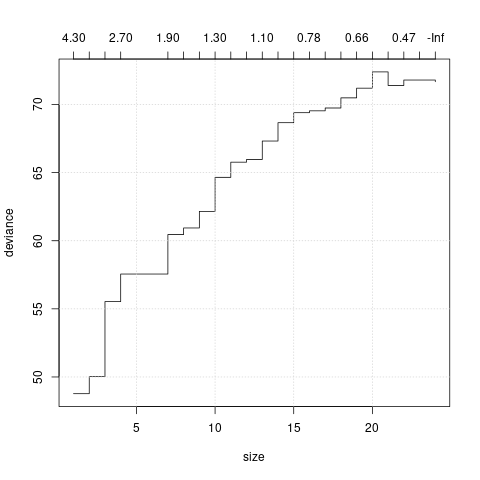

In [74]:
%%R 

# Utilizando validação cruzada para encontrar a melhor árvore
cv.model = cv.tree(df.model)
plot(cv.model); grid()

In [75]:
%%R
best.size = cv.model$size[which(cv.model$dev == min(cv.model$dev))]
best.size

[1] 1


In [76]:
%%R 
cv.model.pruned = prune.tree(df.model, best=2)
summary(cv.model.pruned)


Regression tree:
snip.tree(tree = df.model, nodes = 2:3)
Variables actually used in tree construction:
[1] "X49"
Number of terminal nodes:  2 
Residual mean deviance:  0.2277 = 41.9 / 184 
Distribution of residuals:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-1.390000 -0.293900  0.005155  0.000000  0.291500  1.428000 


**Métricas da Árvore resultante da validação cruzada**

In [77]:
%%R
library(Metrics)

# Previsões no conjunto de treinamento
pred_train <- predict(cv.model.pruned, newdata = train.set)

# Previsões no conjunto de teste
pred_test <- predict(cv.model.pruned, newdata = test.set)

# Calcular o RMSE para os conjuntos de treinamento e teste
rmse_train <- rmse(train.set$y, pred_train)
rmse_test <- rmse(test.set$y, pred_test)

# Exibir os resultados
cat("RMSE no conjunto de treinamento:", round(rmse_train, 4), "\n")
cat("RMSE no conjunto de teste:", round(rmse_test, 4), "\n")

RMSE no conjunto de treinamento: 0.4746 
RMSE no conjunto de teste: 0.455 


**Métricas da Árvore calculada inicialmente**

In [78]:
%%R
# Previsões no conjunto de treinamento
pred_train <- predict(df.model, newdata = train.set)

# Previsões no conjunto de teste
pred_test <- predict(df.model, newdata = test.set)

# Calcular o RMSE para os conjuntos de treinamento e teste
rmse_train <- rmse(train.set$y, pred_train)
rmse_test <- rmse(test.set$y, pred_test)

# Exibir os resultados
cat("RMSE no conjunto de treinamento:", round(rmse_train, 4), "\n")
cat("RMSE no conjunto de teste:", round(rmse_test, 4), "\n")

RMSE no conjunto de treinamento: 0.2367 
RMSE no conjunto de teste: 0.5452 
